Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуйтесь следующей инструкцией: [Как скачать данные с kaggle в colab.](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) Ниже есть необходимый код, вам нужно лишь запрость токен на kaggle и загрузить его.

In [45]:
# !pip install -q kaggle

In [46]:
# from google.colab import files
# uploaded = files.upload()

In [47]:
# !mkdir /root/.kaggle
# !mv kaggle.json /root/.kaggle/kaggle.json
# !kaggle competitions download -c nyc-taxi-trip-duration
# !unzip "/content/nyc-taxi-trip-duration.zip" -d "/content"

In [48]:
# import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [49]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [50]:
df = df.drop(['dropoff_datetime', 'store_and_fwd_flag', 'id'], axis=1)

In [51]:
import datetime as dt
df.pickup_datetime = pd.to_datetime(df.pickup_datetime).map(dt.datetime.toordinal)

In [52]:
df = df.sort_values(by='pickup_datetime')

In [53]:
df.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
333752,1,735964,1,-73.963486,40.768528,-73.969521,40.757580,274
616306,1,735964,1,-73.998032,40.751167,-73.976761,40.751854,455
1391034,1,735964,1,-74.005302,40.728542,-73.978622,40.764221,1070
1138825,2,735964,1,-73.977592,40.632847,-73.977592,40.632847,413
537651,2,735964,2,-73.956978,40.770802,-73.979050,40.785332,540


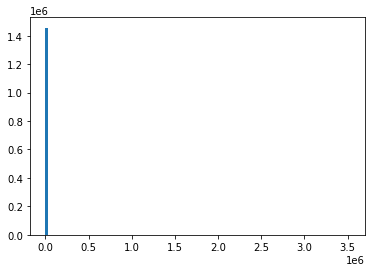

In [54]:
df.trip_duration.hist(bins=100, grid=False, )
plt.show()

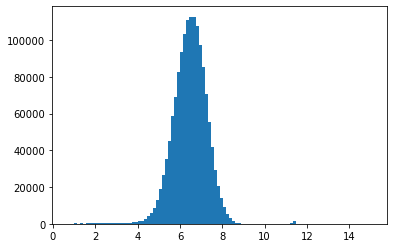

In [55]:
np.log1p(df.trip_duration).hist(bins=100, grid=False)
plt.show()

Построить линейную регрессию зависимости trip_duration от других переменных двумя способами

In [56]:
Y = df['trip_duration'].to_numpy()
X = df.drop(columns='trip_duration')

In [57]:
# With statsmodel
import statsmodels.api as sm
lm = sm.OLS.from_formula('trip_duration ~ vendor_id + dropoff_latitude + dropoff_longitude + pickup_latitude + pickup_longitude + passenger_count + pickup_datetime + vendor_id', df)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     454.6
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:23:33   Log-Likelihood:            -1.4559e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458636   BIC:                         2.912e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.263e+05   6.24e+04     -2.023      0.043   -2.49e+05   -3942.513
vendor_id           203.8172      9.068     22.476      0.000     186.044     221.591
dropoff_latitude  -1704.1814    139.556    -12.211      0.000   -1977.705   -1430.657
dropoff_longitude  -620.6355     99.933     -6.211      0.000    -816.500    -424.771
pickup_latitude   -3704.6107    153.060    -24.204      0.000   -4004.602   -3404.619
pickup_longitude   2556.6840     99.150     25.786      0.000    2362.354    2751.015
passenger_count      10.6583      3.441      3.097      0.002       3.913      17.403
pickup_datetime       0.6664      0.084      7.933      0.000       0.502       0.831
================================================================================
Omnibus:                  8291576.689   Durbin-Watson:                     1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2260156605075543.000
Skew:                         344.110   Prob(JB):                           0.00
Kurtosis:                  192843.153   Cond. No.                       1.06e+10
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# With sklearn
from sklearn.linear_model import LinearRegression

skl_linreg = LinearRegression().fit(X, Y)
skl_linreg.score(X, Y)

0.0021767198187270242